In [12]:
%matplotlib inline
import pylab as pl

In [13]:
import sys
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/analysis')

In [14]:
import numpy as np

In [15]:
import spitzer_plots
from spitzer_plots import show_fov_on_spitzer, contour_levels, get_spitzer_data
from spectralindex import prefixes
from spectral_cube import SpectralCube
from astropy import coordinates
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import visualization
from astropy.visualization import imshow_norm, simple_norm

In [16]:
from astroquery.vizier import Vizier

In [17]:
mipsgal_g12_tbl = Vizier(row_limit=5000).query_region(SkyCoord('18:14:13.37 -17:55:45.2', frame='fk5', unit=(u.h, u.deg)),
                                                      radius=2.5*u.arcmin,
                                                       catalog='J/AJ/149/64/catalog',
                                                      )[0]
glimpse_g12_tbl = Vizier(row_limit=5000).query_region(SkyCoord('18:14:13.37 -17:55:45.2', frame='fk5', unit=(u.h, u.deg)),
                                                      radius=2.5*u.arcmin,
                                                       catalog='II/293/glimpse',
                                                      )[0]
wise_g12_tbl = Vizier(row_limit=5000).query_region(SkyCoord('18:14:13.37 -17:55:45.2', frame='fk5', unit=(u.h, u.deg)),
                                                      radius=2.5*u.arcmin,
                                                       catalog='II/363/unwise',
                                                      )[0]

g12_glimpse_crds = SkyCoord(glimpse_g12_tbl['RAJ2000'].quantity, glimpse_g12_tbl['DEJ2000'].quantity, frame='fk5')
g12_mipsgal_crds = SkyCoord(mipsgal_g12_tbl['RAJ2000'].quantity, mipsgal_g12_tbl['DEJ2000'].quantity, frame='fk5')
g12_wise_crds = SkyCoord(wise_g12_tbl['RAJ2000'].quantity, wise_g12_tbl['DEJ2000'].quantity, frame='fk5')
len(mipsgal_g12_tbl), len(glimpse_g12_tbl), len(wise_g12_tbl)

(3, 616, 334)

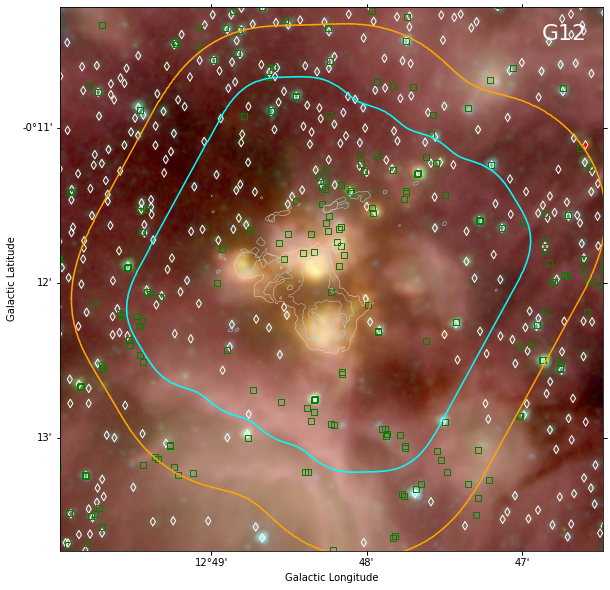

In [18]:
fieldid = 'G12'
basepath = '/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/RestructuredImagingResults'
pfxs = prefixes[fieldid]
fig = show_fov_on_spitzer(**{key: f'{basepath}/{val}' for key,val in pfxs.items()},
                          fieldid=fieldid, spitzerpath=f'{basepath}/spitzer_datapath',
                          contour_level=contour_levels[fieldid])


cube = SpectralCube.read(basepath + '/' + pfxs['finaliter_prefix_b3']+".image.tt0.fits",
                         format='fits', use_dask=False).minimal_subcube()
ww = cube.wcs.celestial
ww._naxis = cube.shape[1:]
#matches = ww.footprint_contains(coords)

#cc = coords[matches]

ax = fig.gca()
#ax.plot(cc.fk5.ra.deg, cc.fk5.dec.deg, 'wo', mfc='none', mec='w', markersize=10, transform=ax.get_transform('fk5'), )

sel = ((glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'] > 0.5) &
       (glimpse_g12_tbl['_4.5mag'] - glimpse_g12_tbl['_5.8mag'] > 0.5))
ax.scatter_coord(g12_mipsgal_crds, marker='o', edgecolor='r', facecolor='r', s=45)
ax.scatter_coord(g12_glimpse_crds, marker='d',
                 #c=glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'], s=45,
                 edgecolor='w',
                 facecolor='none')
#ax.scatter_coord(g12_glimpse_crds[sel], marker='d',
#                 #c=glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'], s=45,
#                 edgecolor='r',
#                 facecolor='none')
ax.scatter_coord(g12_wise_crds, marker='s',
                 #c=glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'], s=45,
                 edgecolor='g',
                 facecolor='none')

ax.axis((100,450,100,450));

In [19]:
center = SkyCoord('18:14:13.37 -17:55:45.2', frame='fk5', unit=(u.h, u.deg))
spitzer_data = get_spitzer_data(center, size=5*u.arcmin)

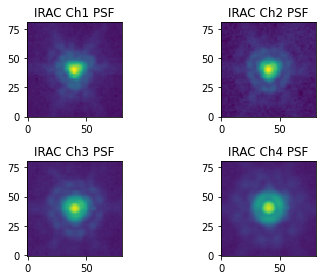

In [10]:
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch
from photutils.datasets import load_irac_psf

hdu1 = load_irac_psf(1)
hdu2 = load_irac_psf(2)
hdu3 = load_irac_psf(3)
hdu4 = load_irac_psf(4)

norm = ImageNormalize(hdu1.data, stretch=LogStretch())

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(hdu1.data, origin='lower', interpolation='nearest',
           norm=norm)
ax1.set_title('IRAC Ch1 PSF')
ax2.imshow(hdu2.data, origin='lower', interpolation='nearest',
           norm=norm)
ax2.set_title('IRAC Ch2 PSF')
ax3.imshow(hdu3.data, origin='lower', interpolation='nearest',
           norm=norm)
ax3.set_title('IRAC Ch3 PSF')
ax4.imshow(hdu4.data, origin='lower', interpolation='nearest',
           norm=norm)
ax4.set_title('IRAC Ch4 PSF')
plt.tight_layout()
plt.show()

In [20]:
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.background import MADStdBackgroundRMS, MMMBackground
from photutils.detection import IRAFStarFinder
from photutils.psf import (DAOGroup, IntegratedGaussianPRF,
                           IterativelySubtractedPSFPhotometry, EPSFModel)

In [35]:
import crowdsource
from crowdsource.crowdsource_base import fit_im, psfmod
import crowdsource.psf
from crowdsource import psf
import time
from astropy.table import Table

In [37]:
import sys
sys.path.append('/orange/adamginsburg/jwst/brick/analysis/')
from crowdsource_catalogs_long import catalog_zoom_diagnostic

Starting cataloging
Importing webbpsf
2023-05-11T13:16:51.326231: Done with imports


In [147]:
t0 = time.time()
data = spitzer_data['I3'][0].data
psf_model = crowdsource.psf.SimplePSF(hdu3.data)
results_unweighted  = fit_im(np.nan_to_num(data), psf_model, weight=np.ones_like(data)/40,#*np.nanmedian(weight),
                             nskyx=0, nskyy=0, refit_psf=False, verbose=True)
print(f"Done with unweighted crowdsource. dt={time.time() - t0}")
stars, modsky, skymsky, psf = results_unweighted
stars = Table(stars)
# crowdsource explicitly inverts x & y from the numpy convention:
# https://github.com/schlafly/crowdsource/issues/11
coords = ww.pixel_to_world(stars['y'], stars['x'])
stars['skycoord'] = coords
stars['x'], stars['y'] = stars['y'], stars['x']

Starting subregion iterations
Subregion iteration 0 starting; dt=0.0005731582641601562
Extension None, iteration  1, found    145 sources;    0 close and    7 faint sources removed.
Starting subregion iterations
Subregion iteration 0 starting; dt=0.0001919269561767578
Extension None, iteration  2, found     44 sources;    0 close and    7 faint sources removed.
Starting subregion iterations
Subregion iteration 0 starting; dt=0.0001952648162841797
Extension None, iteration  3, found     87 sources;    0 close and    3 faint sources removed.
Starting subregion iterations
Subregion iteration 0 starting; dt=0.0002033710479736328
Extension None, iteration  4, found    121 sources;    0 close and    1 faint sources removed.
Starting subregion iterations
Subregion iteration 0 starting; dt=0.00020694732666015625
Extension None, iteration  5, found     94 sources;    0 close and    0 faint sources removed.
Starting subregion iterations
Subregion iteration 0 starting; dt=0.00020647048950195312
D

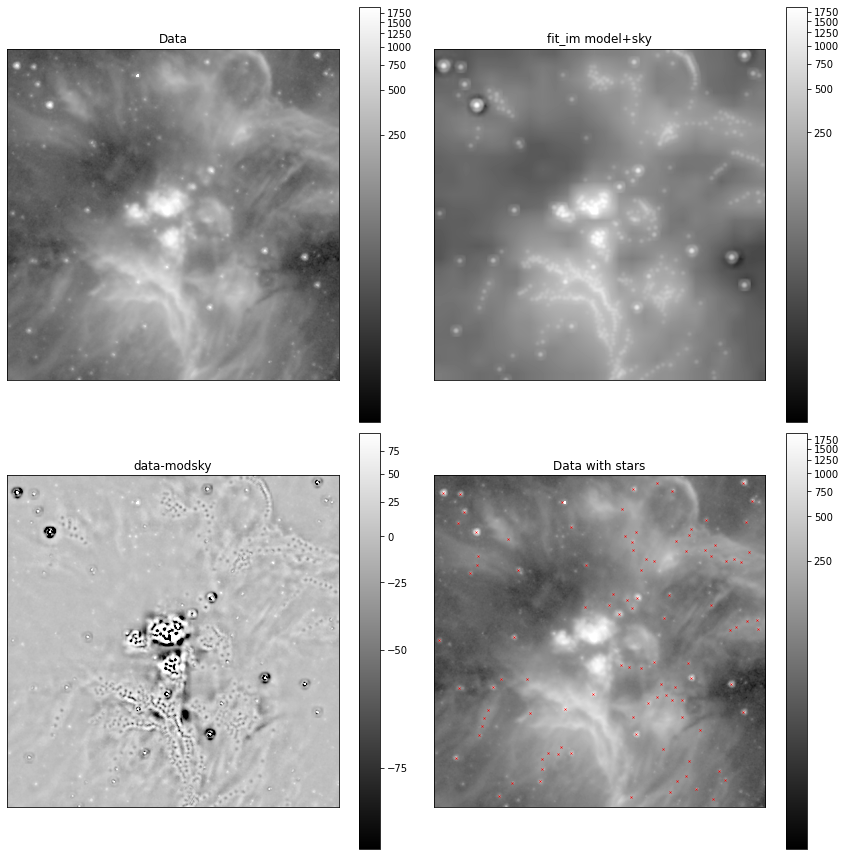

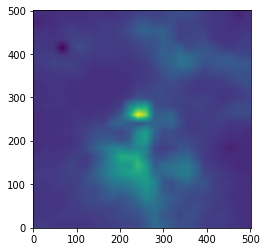

In [148]:
nullslice = (slice(None), slice(None))
ok  = (stars['qf'] > 0.9) & (stars['fracflux'] > 0.8) & (stars['spread_model'] < 0.25)
catalog_zoom_diagnostic(data, modsky, nullslice, stars[ok])
pl.figure().gca().imshow(skymsky)

Done with unweighted crowdsource. dt=34.62613081932068


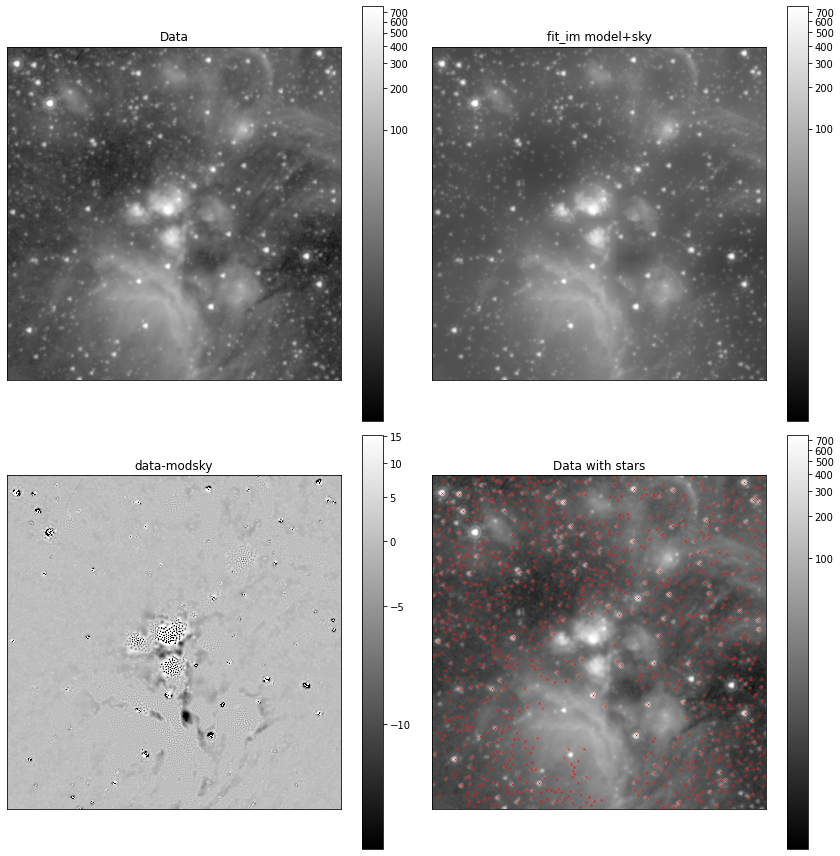

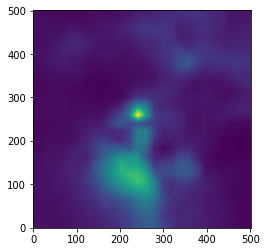

In [149]:
t0 = time.time()
data = spitzer_data['I2'][0].data
psf_model = crowdsource.psf.SimplePSF(hdu2.data)
results_unweighted  = fit_im(np.nan_to_num(data), psf_model, weight=np.ones_like(data)/1,#*np.nanmedian(weight),
                             #psfvalsharpcutfac=0.8, psfsharpsat=0.9,
                             nskyx=0, nskyy=0, refit_psf=True, verbose=False)
print(f"Done with unweighted crowdsource. dt={time.time() - t0}")
stars, modsky, skymsky, psf = results_unweighted
stars = Table(stars)
# crowdsource explicitly inverts x & y from the numpy convention:
# https://github.com/schlafly/crowdsource/issues/11
coords = ww.pixel_to_world(stars['y'], stars['x'])
stars['skycoord'] = coords
stars['x'], stars['y'] = stars['y'], stars['x']
nullslice = (slice(None), slice(None))

ok  = (stars['qf'] > 0.9) & (stars['fracflux'] > 0.8) & (stars['spread_model'] < 0.25)

catalog_zoom_diagnostic(data, modsky, nullslice, stars[ok])
pl.figure().gca().imshow(skymsky)

Done with unweighted crowdsource. dt=8.610660314559937


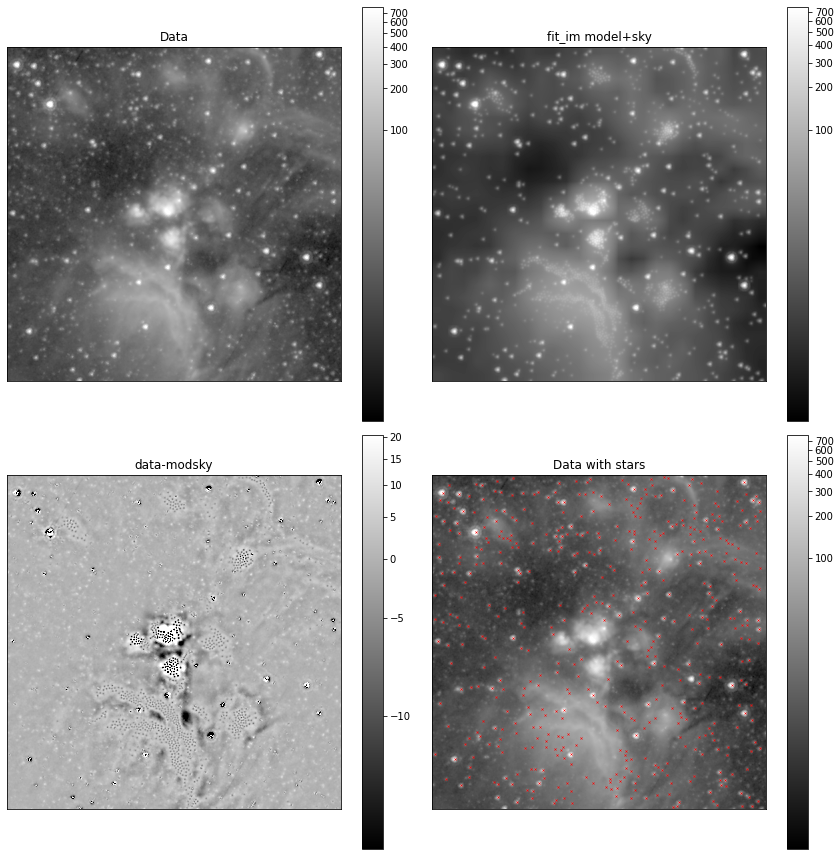

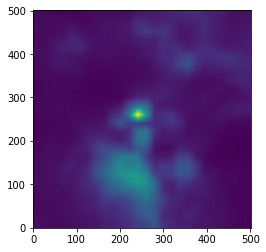

In [150]:
t0 = time.time()
data = spitzer_data['I2'][0].data
psf_model = crowdsource.psf.SimplePSF(hdu2.data)
results_unweighted  = fit_im(np.nan_to_num(data), psf_model, weight=np.ones_like(data)/5,#*np.nanmedian(weight),
                             #psfvalsharpcutfac=0.95, psfsharpsat=0.95,
                             #titer_thresh=1.1, blendthreshu=0.5,
                             nskyx=0, nskyy=0, refit_psf=True, verbose=False)
print(f"Done with unweighted crowdsource. dt={time.time() - t0}")
stars, modsky, skymsky, psf = results_unweighted
stars = Table(stars)
# crowdsource explicitly inverts x & y from the numpy convention:
# https://github.com/schlafly/crowdsource/issues/11
coords = ww.pixel_to_world(stars['y'], stars['x'])
stars['skycoord'] = coords
stars['x'], stars['y'] = stars['y'], stars['x']
nullslice = (slice(None), slice(None))
ok  = (stars['qf'] > 0.9) & (stars['fracflux'] > 0.8) & (stars['spread_model'] < 0.25)
catalog_zoom_diagnostic(data, modsky, nullslice, stars[ok])
pl.figure().gca().imshow(skymsky)

Done with unweighted crowdsource. dt=3.2031924724578857


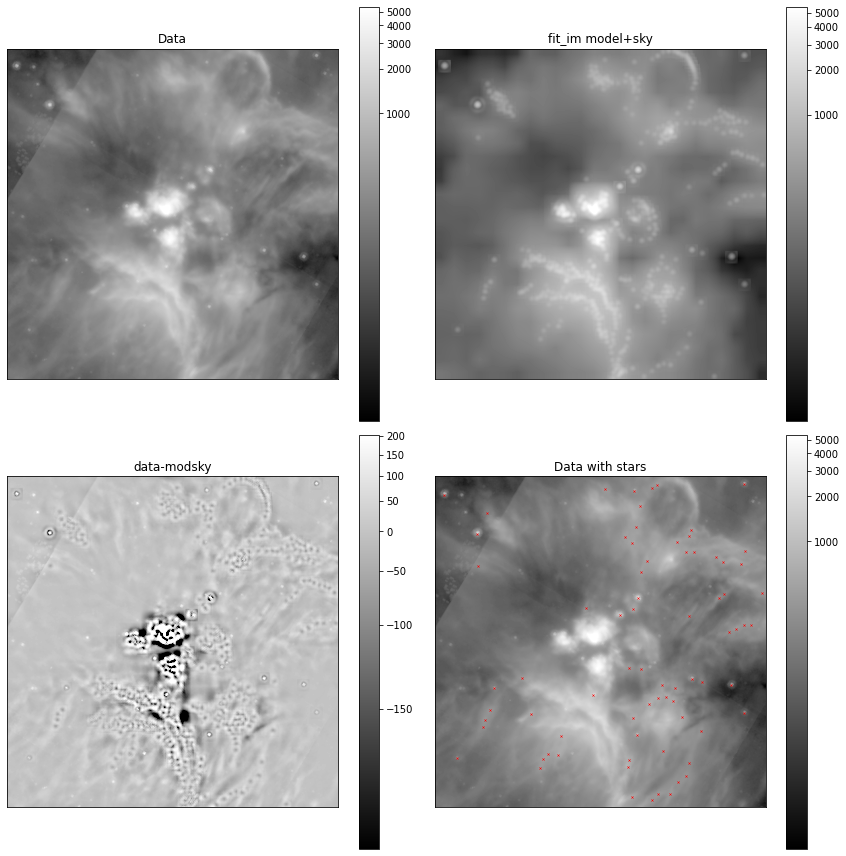

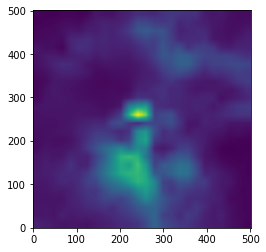

In [152]:
t0 = time.time()
data = spitzer_data['I4'][0].data
psf_model = crowdsource.psf.SimplePSF(hdu4.data)
results_unweighted  = fit_im(np.nan_to_num(data), psf_model, weight=np.ones_like(data)/100,#*np.nanmedian(weight),
                             nskyx=0, nskyy=0, refit_psf=False, verbose=False)
print(f"Done with unweighted crowdsource. dt={time.time() - t0}")
stars, modsky, skymsky, psf = results_unweighted
stars = Table(stars)
# crowdsource explicitly inverts x & y from the numpy convention:
# https://github.com/schlafly/crowdsource/issues/11
coords = ww.pixel_to_world(stars['y'], stars['x'])
stars['skycoord'] = coords
stars['x'], stars['y'] = stars['y'], stars['x']
nullslice = (slice(None), slice(None))
ok  = (stars['qf'] > 0.9) & (stars['fracflux'] > 0.8) & (stars['spread_model'] < 0.25)
catalog_zoom_diagnostic(data, modsky, nullslice, stars[ok])
pl.figure().gca().imshow(skymsky)

(100.0, 200.0, 250.0, 350.0)

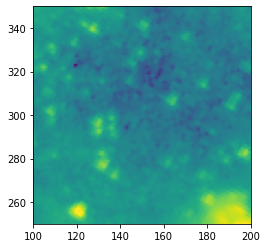

In [247]:
pl.imshow(data, norm=simple_norm(data, max_percent=99, stretch='log'))
pl.gca().axis([100,200,250,350])

(250.0, 350.0, 120.0, 220.0)

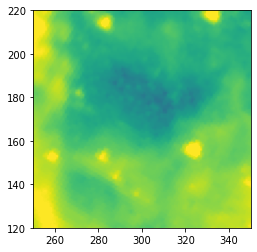

In [262]:
data = spitzer_data['I1'][0].data
pl.imshow(data, norm=simple_norm(data, max_percent=99, stretch='log'))
pl.gca().axis([250,350,120,220])

In [230]:
import mpl_plot_templates
import astropy
import astropy.visualization
from astropy.wcs import WCS

In [231]:
import imp
imp.reload(mpl_plot_templates)
imp.reload(mpl_plot_templates.inset_plots)

<module 'mpl_plot_templates.inset_plots' from '/orange/adamginsburg/repos/mpl_plot_templates/mpl_plot_templates/inset_plots.py'>

In [284]:
from mpl_plot_templates.inset_plots import mark_inset_otherdata, mark_inset_generic, mark_inset_otherdata_full, hide_ticks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Done with unweighted crowdsource. dt=48.012765407562256


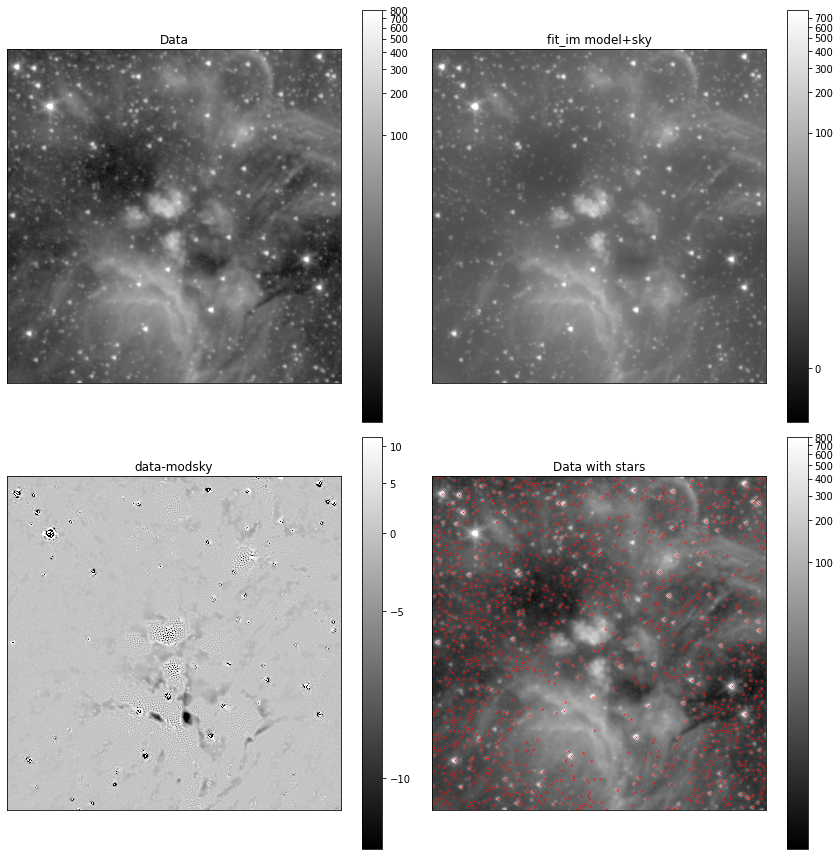

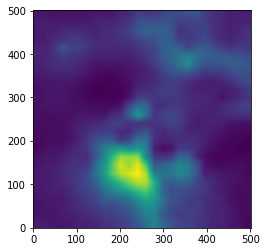

In [263]:
t0 = time.time()
data = spitzer_data['I1'][0].data
psf_model = crowdsource.psf.SimplePSF(hdu1.data)
results_unweighted  = fit_im(np.nan_to_num(data), psf_model, weight=np.ones_like(data)/0.5,#*np.nanmedian(weight),
                             psfvalsharpcutfac=0.95, psfsharpsat=0.95,
                             titer_thresh=1.5,
                             nskyx=0, nskyy=0, refit_psf=True, verbose=False)
print(f"Done with unweighted crowdsource. dt={time.time() - t0}")
stars, modsky, skymsky, psf = results_unweighted
stars = Table(stars)
# crowdsource explicitly inverts x & y from the numpy convention:
# https://github.com/schlafly/crowdsource/issues/11
coords = ww.pixel_to_world(stars['y'], stars['x'])
stars['skycoord'] = coords
stars['x'], stars['y'] = stars['y'], stars['x']
nullslice = (slice(None), slice(None))
ok  = (stars['qf'] > 0.8) & (stars['fracflux'] > 0.7) & (stars['spread_model'] < 0.15)
catalog_zoom_diagnostic(data, modsky, nullslice, stars[ok])
pl.figure().gca().imshow(skymsky)

In [286]:
def hide_ticks(ax):
    ra = ax.coords['glon']
    dec = ax.coords['glat']
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ra.set_ticks_visible(False)
    dec.set_ticks_visible(False)
    ra.set_axislabel('')
    dec.set_axislabel('')
    ra.ticklabels.set_visible(False)
    dec.ticklabels.set_visible(False)

In [292]:
twomass_g12_tbl = Vizier(row_limit=5000).query_region(SkyCoord('18:14:13.37 -17:55:45.2', frame='fk5', unit=(u.h, u.deg)),
                                                      radius=2.5*u.arcmin,
                                                       catalog='II/246',
                                                      )[0]
g12_twomass_crds = SkyCoord(twomass_g12_tbl['RAJ2000'].quantity, twomass_g12_tbl['DEJ2000'].quantity, frame='fk5')

In [288]:
pl.rcParams['font.size'] = 16

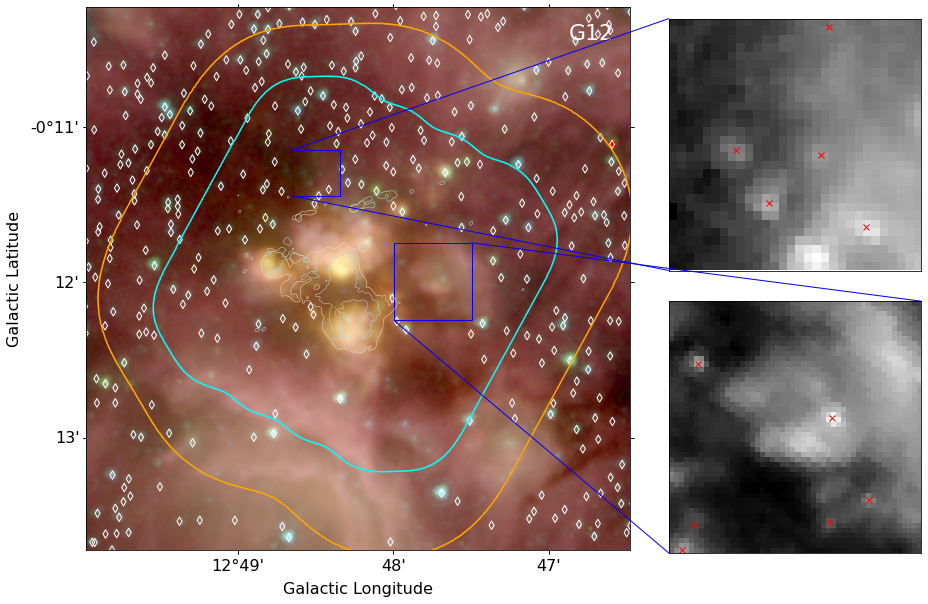

In [306]:

fieldid = 'G12'
basepath = '/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/RestructuredImagingResults'
pfxs = prefixes[fieldid]
fig = show_fov_on_spitzer(**{key: f'{basepath}/{val}' for key,val in pfxs.items()},
                          fieldid=fieldid, spitzerpath=f'{basepath}/spitzer_datapath',
                          contour_level=contour_levels[fieldid])


cube = SpectralCube.read(basepath + '/' + pfxs['finaliter_prefix_b3']+".image.tt0.fits",
                         format='fits', use_dask=False).minimal_subcube()
ww = cube.wcs.celestial
ww._naxis = cube.shape[1:]
#matches = ww.footprint_contains(coords)

#cc = coords[matches]

ax = fig.gca()
#ax.plot(cc.fk5.ra.deg, cc.fk5.dec.deg, 'wo', mfc='none', mec='w', markersize=10, transform=ax.get_transform('fk5'), )

sel = ((glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'] > 0.5) &
       (glimpse_g12_tbl['_4.5mag'] - glimpse_g12_tbl['_5.8mag'] > 0.5))
ax.scatter_coord(g12_mipsgal_crds, marker='o', edgecolor='r', facecolor='r', s=45)
ax.scatter_coord(g12_glimpse_crds, marker='d',
                 #c=glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'], s=45,
                 edgecolor='w',
                 facecolor='none')
#ax.scatter_coord(g12_glimpse_crds[sel], marker='d',
#                 #c=glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'], s=45,
#                 edgecolor='r',
#                 facecolor='none')
#ax.scatter_coord(g12_wise_crds, marker='s',
                 #c=glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'], s=45,
#                 edgecolor='g',
#                 facecolor='none')

ax.axis((100,450,100,450));

slc = slice(300,330), slice(210,240)
axins = inset_axes(ax, axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   bbox_to_anchor=(1, 0.5, 0.55, 0.0),
                   loc='lower right',
                   bbox_transform=ax.transAxes, 
                   width=3.5, height=3.5,
                   axes_kwargs=dict(wcs=WCS(spitzer_data['I1'][0].header)[slc]))
data = spitzer_data['I1'][0].data[slc]
axins.imshow(data, norm=simple_norm(data, stretch='asinh', max_percent=99.995,
                                    #min_cut=0
                                    min_percent=0.1,
                                   ), cmap='gray')
axlims = axins.axis()
axins.plot(stars['x'][ok]-slc[1].start, stars['y'][ok]-slc[0].start, 'rx')
#axins.axis([100,200,250,350])
axins.axis(axlims)
mark_inset_otherdata_full(axins, ax, data, loc1=2, loc2=3)
hide_ticks(axins)


slc = slice(220,270), slice(275,325)
axins = inset_axes(ax, axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   bbox_to_anchor=(1, -0.02, 0.55, 0.0),
                   loc='lower right',
                   bbox_transform=ax.transAxes, 
                   width=3.5, height=3.5,
                   axes_kwargs=dict(wcs=WCS(spitzer_data['I1'][0].header)[slc]))
data = spitzer_data['I1'][0].data[slc]
axins.imshow(data, norm=simple_norm(data, stretch='asinh', max_percent=99.995,
                                    #min_cut=0
                                    min_percent=0.1,
                                   ), cmap='gray')
axlims = axins.axis()
axins.plot(stars['x'][ok]-slc[1].start, stars['y'][ok]-slc[0].start, 'rx')
#axins.axis([100,200,250,350])
axins.axis(axlims)
mark_inset_otherdata_full(axins, ax, data, loc1=1, loc2=3)
hide_ticks(axins)


pl.savefig('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/SPICYvsGLIMPSE/G12Zoom1.png', bbox_inches='tight', dpi=200)

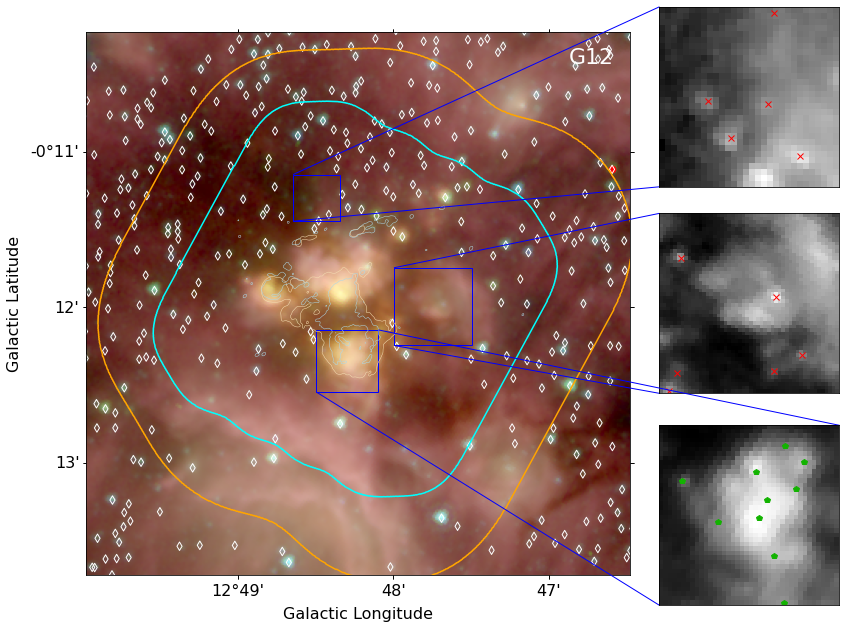

In [311]:
fieldid = 'G12'
basepath = '/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/RestructuredImagingResults'
pfxs = prefixes[fieldid]
fig = show_fov_on_spitzer(**{key: f'{basepath}/{val}' for key,val in pfxs.items()},
                          fieldid=fieldid, spitzerpath=f'{basepath}/spitzer_datapath',
                          contour_level=contour_levels[fieldid])


cube = SpectralCube.read(basepath + '/' + pfxs['finaliter_prefix_b3']+".image.tt0.fits",
                         format='fits', use_dask=False).minimal_subcube()
ww = cube.wcs.celestial
ww._naxis = cube.shape[1:]
#matches = ww.footprint_contains(coords)

#cc = coords[matches]

ax = fig.gca()
#ax.plot(cc.fk5.ra.deg, cc.fk5.dec.deg, 'wo', mfc='none', mec='w', markersize=10, transform=ax.get_transform('fk5'), )

sel = ((glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'] > 0.5) &
       (glimpse_g12_tbl['_4.5mag'] - glimpse_g12_tbl['_5.8mag'] > 0.5))
ax.scatter_coord(g12_mipsgal_crds, marker='o', edgecolor='r', facecolor='r', s=45)
ax.scatter_coord(g12_glimpse_crds, marker='d',
                 #c=glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'], s=45,
                 edgecolor='w',
                 facecolor='none')
#ax.scatter_coord(g12_glimpse_crds[sel], marker='d',
#                 #c=glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'], s=45,
#                 edgecolor='r',
#                 facecolor='none')
#ax.scatter_coord(g12_wise_crds, marker='s',
                 #c=glimpse_g12_tbl['_3.6mag'] - glimpse_g12_tbl['_4.5mag'], s=45,
#                 edgecolor='g',
#                 facecolor='none')

ax.axis((100,450,100,450));

slc = slice(300,330), slice(210,240)
axins = inset_axes(ax, axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   bbox_to_anchor=(1, 0.7, 0.4, 0.0),
                   loc='lower right',
                   bbox_transform=ax.transAxes, 
                   width=2.5, height=2.5,
                   axes_kwargs=dict(wcs=WCS(spitzer_data['I1'][0].header)[slc]))
data = spitzer_data['I1'][0].data[slc]
axins.imshow(data, norm=simple_norm(data, stretch='asinh', max_percent=99.995,
                                    #min_cut=0
                                    min_percent=0.1,
                                   ), cmap='gray')
axlims = axins.axis()
axins.plot(stars['x'][ok]-slc[1].start, stars['y'][ok]-slc[0].start, 'rx')
#axins.axis([100,200,250,350])
axins.axis(axlims)
mark_inset_otherdata_full(axins, ax, data, loc1=2, loc2=3)
hide_ticks(axins)


slc = slice(220,270), slice(275,325)
axins = inset_axes(ax, axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   bbox_to_anchor=(1, 0.32, 0.4, 0.0),
                   loc='lower right',
                   bbox_transform=ax.transAxes, 
                   width=2.5, height=2.5,
                   axes_kwargs=dict(wcs=WCS(spitzer_data['I1'][0].header)[slc]))
data = spitzer_data['I1'][0].data[slc]
axins.imshow(data, norm=simple_norm(data, stretch='asinh', max_percent=99.995,
                                    #min_cut=0
                                    min_percent=0.1,
                                   ), cmap='gray')
axlims = axins.axis()
axins.plot(stars['x'][ok]-slc[1].start, stars['y'][ok]-slc[0].start, 'rx')
#axins.axis([100,200,250,350])
axins.axis(axlims)
mark_inset_otherdata_full(axins, ax, data, loc1=2, loc2=3)
hide_ticks(axins)


slc = slice(190,230), slice(225,265)
axins = inset_axes(ax, axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   bbox_to_anchor=(1, -0.07, 0.4, 0.0),
                   loc='lower right',
                   bbox_transform=ax.transAxes, 
                   width=2.5, height=2.5,
                   axes_kwargs=dict(wcs=WCS(spitzer_data['I1'][0].header)[slc]))
data = spitzer_data['I1'][0].data[slc]
axins.imshow(data, norm=simple_norm(data, stretch='asinh', max_percent=99.995,
                                    #min_cut=0
                                    min_percent=0.1,
                                   ), cmap='gray')
axlims = axins.axis()
#axins.plot(stars['x'][ok]-slc[1].start, stars['y'][ok]-slc[0].start, 'rx')
axins.plot_coord(g12_twomass_crds, 'p', color=(0.07, 0.7, 0))
axins.axis(axlims)
mark_inset_otherdata_full(axins, ax, data, loc1=1, loc2=3)
hide_ticks(axins)
pl.savefig('/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/SPICYvsGLIMPSE/G12Zoom2.png', bbox_inches='tight', dpi=200)

In [53]:
%pip install julia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 1.3 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [54]:
import julia

In [55]:
julia.install()

[ Info: Julia version info


Julia Version 1.7.3
Commit 742b9abb4d* (2022-05-06 12:58 UTC)
Platform Info:
  OS: Linux (x86_64-conda-linux-gnu)
      "Red Hat Enterprise Linux Server release 7.9 (Maipo)"
  uname: Linux 3.10.0-1160.88.1.el7.x86_64 #1 SMP Sat Feb 18 13:27:00 UTC 2023 x86_64 x86_64
  CPU: AMD EPYC 7702 64-Core Processor: 
                  speed         user         nice          sys         idle          irq
       #1-128  1996 MHz  2123241841 s       3442 s  145062573 s  503813156 s          0 s
       
  Memory: 1005.5069236755371 GB (853747.48046875 MB free)
  Uptime: 2.17091796e6 sec
  Load Avg:  267.67  269.21  269.62
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, znver2)
Environment:
  JULIA_SSL_CA_ROOTS_PATH = /blue/adamginsburg/adamginsburg/miniconda3/envs/python39/ssl/cacert.pem
  JULIA_DEPOT_PATH = /blue/adamginsburg/adamginsburg/miniconda3/envs/python39/share/julia:
  JULIA_PROJECT = @python39
  JULIA_PROJECT_BACKUP = 
  JULIA_LOAD_PATH = @:@python39:@stdlib
  JULIA_DE

[ Info: Julia executable: /blue/adamginsburg/adamginsburg/miniconda3/envs/python39/bin/julia
[ Info: Trying to import PyCall...
┌ Warning: PyCall is already installed.  However, you may have trouble using
│ this Python executable because it is statically linked to libpython.
│ 
│ For more information, see:
│     https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
│ 
│ Python executable:
│     /orange/adamginsburg/miniconda3/envs/python39/bin/python
│ Julia executable:
│     /blue/adamginsburg/adamginsburg/miniconda3/envs/python39/bin/julia
└ @ Main /blue/adamginsburg/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/julia/install.jl:90


In [58]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

import julia.Pkg
julia.Pkg.add('CloudCovErr')

    Updating registry at `/blue/adamginsburg/adamginsburg/miniconda3/envs/python39/share/julia/registries/General.toml`
   Resolving package versions...
  No Changes to `/blue/adamginsburg/adamginsburg/miniconda3/envs/python39/share/julia/environments/python39/Project.toml`
  No Changes to `/blue/adamginsburg/adamginsburg/miniconda3/envs/python39/share/julia/environments/python39/Manifest.toml`


In [59]:
julia.Pkg.Use('CloudCovErr')

AttributeError: Use